In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime
from tqdm import tqdm

from unityagents import UnityEnvironment

from inspect import getsource
import torch
import random
from collections import deque

import colorsys

from drl_nav.agent import Agent_PER, Agent_DQN_pixel
from drl_nav.network.heads import LabelizerNet, AuxNet, QNet
from drl_nav.network.bodies import ConvBody

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


__________

In [4]:
banana_path= r"../environment/VisualBanana_Windows_x86_64/Banana.exe"
visual_banana_path= r"../environment/VisualBanana_Windows_x86_64/Banana.exe"
env = UnityEnvironment(file_name=visual_banana_path)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
n_A = brain.vector_action_space_size
state = env_info.vector_observations[0]
n_S = len(state)

print('Number of agents:', len(env_info.agents))
print('Number of actions:', n_A)
print("State's shape:", state.shape)

Number of agents: 1
Number of actions: 4
State's shape: (0,)


______

##### Debug

In [114]:
a = np.array([
    [
        [111, 112, 113, 114],
        [121, 122, 123, 124],
        [131, 132, 133, 134],
    ],
    [
        [211, 212, 213, 214],
        [221, 222, 223, 224],
        [231, 232, 233, 234]
    ]
])
print(a.shape)

(2, 3, 4)


_____
#### Helper functions


In [6]:
def select_action(last_action, epsilon=0.75):
    """
    Exploratory action selection strategy that favor forward motion and action conservation.
    Actions explanation:
    0: forward
    1: backward
    2: left
    3: right
    """
    if np.random.random() > epsilon:
        action = np.random.choice([0, 1, 2, 3], p=[.5, .1, .2, .2])
    else:
        action = last_action
        
    return action

def count_parameters(model):
    """ return the number of parameters of a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

_____
## Experimentations

###### TODO
- Observe the learning curve on the color detection.
- How it evolve when the agent stop working on its color detection ?
- Does we need to learn color detection and later refresh that skill ?
- Obviously compare with and without color detection.
- decrease the spatial dimension of the input.
- user replay buffer both for learning Q values and color detection. (labelizing is costly and labels are often correlated.)
- tests image detection on MNIST

#### One espisode of interaction

In [ ]:
count_parameters(conv_body)
count_parameters(aux_net)
count_parameters(q_net)

conv_body.parameters

In [142]:
labelizer = LabelizerNet()

conv_body = ConvBody() #decrease the spatial dimension of the output.
q_net = QNet(conv_body, n_A)
aux_net = AuxNet(conv_body, n_directions=3, n_colors=2)

criterion_q = nn.MSELoss() # MSE
optimizer_q = torch.optim.Adam(q_net.parameters()) # set the learning rate

criterion_aux = nn.CrossEntropyLoss() # CrossEntropy
optimizer_aux = torch.optim.Adam(aux_net.parameters())

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

In [8]:
agent = Agent_DQN_pixel(n_A)

#### One episode no buffer.

In [98]:
%%timeit

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

score, step, last_action = 0, 0 ,0

while True:
    
    action = select_action(last_action)
    last_action = action
    
    env_info = env.step(action)[brain_name]      
    next_state = env_info.visual_observations[0] 
    reward = env_info.rewards[0]                 
    done = env_info.local_done[0]                
    
    score += reward                               
    state = next_state  
    step += 1
    
    # step
    state_torch = torch.from_numpy(np.moveaxis(state, 3, 1)).float()
    
    yellow_labels, blue_labels = labelizer(torch.squeeze(state_torch))
    colors_labels = torch.from_numpy(np.concatenate((yellow_labels, blue_labels)).reshape(1,-1)).float()
    color_pred = aux_net(state_torch)
    
    optimizer_aux.zero_grad()
    loss_color_detection = criterion_aux(color_pred, colors_labels)
    loss_color_detection.backward()
    optimizer_aux.step()
    
    if (done | step > 100):                                      
        break
    
print("Score: {}".format(score))

Score: 0.0
Score: 0.0
Score: 0.0
Score: 2.0
Score: -2.0
Score: 0.0
Score: 0.0
Score: 2.0
5.13 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### One episode with buffer.

In [102]:
color_pred_1 = color_pred

In [ ]:
color_pred_1. color_pred

In [109]:
torch.cat((color_pred_1, color_pred), 0).size()

torch.Size([2, 6])

In [107]:
%%time

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

score, step, last_action = 0, 0 ,0
color_labels = []
colors_pred = []


while True:
    
    action = select_action(last_action)
    last_action = action
    
    env_info = env.step(action)[brain_name]      
    next_state = env_info.visual_observations[0] 
    reward = env_info.rewards[0]                 
    done = env_info.local_done[0]                
    
    score += reward                               
    state = next_state  
    step += 1
    
    # step
    state_torch = torch.from_numpy(np.moveaxis(state, 3, 1)).float()
    
    yellow_labels, blue_labels = labelizer(torch.squeeze(state_torch))
    colors_labels = torch.from_numpy(np.concatenate((yellow_labels, blue_labels))).float()
    color_pred = aux_net(state_torch)

    if (done | step > 100):                                      
        break
    
print("Score: {}".format(score))

Score: 1.0
Wall time: 4.35 s


In [ ]:
Agent_DQN_pixel(n)N

In [ ]:
    optimizer_aux.zero_grad()
    loss_color_detection = criterion_aux(color_pred, colors_labels)
    loss_color_detection.backward()
    optimizer_aux.step()

#### 2000 episodes color detection performances

In [143]:
%%time

N_EPISODES = 2_000

errors_color_detection = []
scores = []

for i in tqdm(range(1, N_EPISODES + 1)):
    
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.visual_observations[0]    
    score, step, last_action = 0, 0 ,0
    errors_color_detection_episode = []
    
    while True:
        
        action = select_action(last_action)
        last_action = action
        
        env_info = env.step(action)[brain_name]      
        next_state = env_info.visual_observations[0] 
        reward = env_info.rewards[0]                 
        done = env_info.local_done[0]                
        
        score += reward                               
        state = next_state  
        step += 1
        
        # step
        state_torch = torch.from_numpy(np.moveaxis(state, 3, 1)).float()
        
        yellow_labels, blue_labels = labelizer(torch.squeeze(state_torch))
        colors_labels = torch.from_numpy(np.concatenate((yellow_labels, blue_labels)).reshape(1,-1)).float()
        color_pred = aux_net(state_torch)
        print(color_pred)
        
        optimizer_aux.zero_grad()
        loss_color_detection = criterion_aux(color_pred, colors_labels)
        loss_color_detection.backward()
        optimizer_aux.step()
        errors_color_detection_episode.append(loss_color_detection.item())
        
        if (done | step > 100):
            scores.append(score)
            errors_color_detection.append(np.mean(errors_color_detection_episode))
            break

100%|██████████| 2000/2000 [2:54:17<00:00,  5.23s/it]  

Wall time: 2h 54min 17s


In [150]:
color_pred

tensor([[9.6037e-23, 5.3695e-23, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       grad_fn=<SigmoidBackward0>)

In [149]:
colors_labels

tensor([[0., 0., 0., 0., 1., 1.]])

In [141]:
errors_color_detection_backup = errors_color_detection.copy()

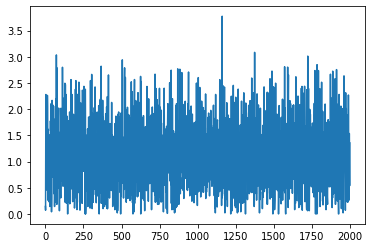

In [144]:
plt.plot(errors_color_detection)

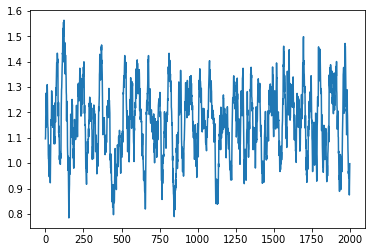

In [148]:
error_detection_avg = []
window_size = 20

for i in range(len(errors_color_detection)):
    error_detection_avg.append(
        np.mean(
            errors_color_detection[max(0, i-window_size//2): min(len(errors_color_detection)-1, i+window_size//2)]))
    
plt.plot(error_detection_avg)

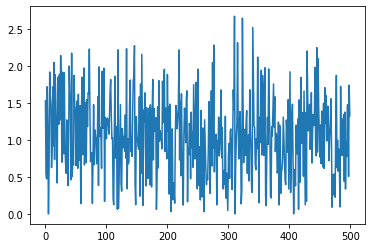

In [136]:
plt.plot(errors_color_detection)

In [139]:
error_detection_avg = []
window_size = 50

for i in range(len(errors_color_detection)):
    error_detection_avg.append(
        np.mean(
            errors_color_detection[max(0, i-window_size//2): min(len(errors_color_detection)-1, i+window_size//2)]))

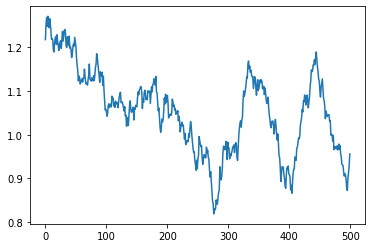

In [140]:
plt.plot(error_detection_avg)

__________

In [65]:
import torch
import torch.nn as nn

input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)

mae_loss = nn.CrossEntropyLoss()
output = mae_loss(input, target)
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[-0.4111,  0.0346,  0.9377,  0.3446,  0.0206],
        [-0.2474,  1.7471, -1.0637,  0.6581, -0.1796],
        [-0.0752,  0.1035,  1.1926, -0.5212,  1.1132]], requires_grad=True)
target:  tensor([[-1.7188,  0.4338, -0.8110,  1.8322,  0.3109],
        [-0.8747, -0.2675,  1.5537, -2.0704, -0.0802],
        [-0.3607,  2.3527,  0.3252,  0.4306, -1.9217]])
output:  tensor(1.3806, grad_fn=<L1LossBackward0>)
